In [1]:
#pip install category_encoders

In [2]:
#pip install lightgbm

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle, islice
import datetime as datetime
import glob
from matplotlib import pyplot
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
import warnings
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
%matplotlib inline

plt.style.use('default')
sns.set(style="whitegrid")
pd.options.display.float_format = '{:20,.2f}'.format
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (18, 5)

# Train

__Lectura de datos__

In [4]:
train = pd.read_csv('Train_TP2_Datos_2020-2C.csv')

train = train[(train.Stage == 'Closed Won') | (train.Stage == 'Closed Lost')]
train['Stage'] = train['Stage'].transform(func=lambda x : 1 if x=='Closed Won' else 0)

train = train.drop('Last_Activity', axis=1) #Todos datos nulos
train = train.drop('Actual_Delivery_Date', axis=1) #Todos datos nulos
train = train.drop('Submitted_for_Approval', axis=1) #Todos los datos en cero
train = train.drop('Prod_Category_A', axis=1) #Todos en none
train = train.drop('Sales_Contract_No', axis=1) #Para evitar el problema de target leakage
train = train.drop('Opportunity_Name', axis=1) #Redundante si tenemos Opportunity_ID

***

__FEATURES__

__Aprobación especial de su precio total__

In [5]:
train['Pricing, Delivery_Terms_Quote_Appr'] = train['Pricing, Delivery_Terms_Quote_Appr']\
                                                .transform(func=lambda x : 'Necesita' if x==1 else 'NoNecesita')
train['Pricing, Delivery_Terms_Approved'] = train['Pricing, Delivery_Terms_Approved']\
                                                .transform(func=lambda x : 'Obtuvo' if x==1 else 'NoObtuvo')

train['Aprobacion_Especial'] = train['Pricing, Delivery_Terms_Quote_Appr']+train['Pricing, Delivery_Terms_Approved']

train = train.drop('Pricing, Delivery_Terms_Quote_Appr', axis=1)
train = train.drop('Pricing, Delivery_Terms_Approved', axis=1)

***

__TRF promedio__

In [6]:
train['TRF_promedio'] = train.groupby('Opportunity_ID')['TRF'].transform('mean')
train = train.drop('TRF', axis=1)

***

__Total Taxable Amount (converted)__

In [7]:
#Completo datos faltantes con Total Amount
train['Total_Taxable_Amount'].loc[train.Total_Taxable_Amount==0.00] = train.loc[train.Total_Taxable_Amount==0.00]\
                                            .groupby(['Opportunity_ID'])['Total_Amount'].transform('sum')

#Convierto a una misma moneda (a dólares) con la información que ya viene en ASP, ASP_Currency y ASP_(converted)
toEUR = train[train.ASP_Currency=='EUR'].head(1)[['ASP_(converted)']].iloc[0,0]/train[train.ASP_Currency=='EUR']\
        .head(1)[['ASP']].iloc[0,0]
toAUD = train[train.ASP_Currency=='AUD'].head(1)[['ASP_(converted)']].iloc[0,0]/train[train.ASP_Currency=='AUD']\
        .head(1)[['ASP']].iloc[0,0]
toGBP = train[train.ASP_Currency=='GBP'].head(1)[['ASP_(converted)']].iloc[0,0]/train[train.ASP_Currency=='GBP']\
        .head(1)[['ASP']].iloc[0,0]
toJPY = train[['ASP_(converted)']].iloc[12,0]/train[['ASP']].iloc[12,0]
#En el head(1) de JPY justo habia un nan. Ese numero magico 12 corresponde a la primera fila de moneda JPY con un valor valido

train['Total_Taxable_Amount_(converted)']=0.0
train['Total_Taxable_Amount_(converted)'].loc[train['Total_Taxable_Amount_Currency']=='EUR'] = \
                                                        train['Total_Taxable_Amount'].apply(lambda x: x*toEUR)
train['Total_Taxable_Amount_(converted)'].loc[train['Total_Taxable_Amount_Currency']=='JPY'] = \
                                                        train['Total_Taxable_Amount'].apply(lambda x: x*toJPY)
train['Total_Taxable_Amount_(converted)'].loc[train['Total_Taxable_Amount_Currency']=='AUD'] = \
                                                        train['Total_Taxable_Amount'].apply(lambda x: x*toAUD)
train['Total_Taxable_Amount_(converted)'].loc[train['Total_Taxable_Amount_Currency']=='GBP'] = \
                                                        train['Total_Taxable_Amount'].apply(lambda x: x*toGBP)
train['Total_Taxable_Amount_(converted)'].loc[train['Total_Taxable_Amount_Currency']=='USD'] = \
                                                        train['Total_Taxable_Amount'].apply(lambda x: x)

train = train.drop('Total_Taxable_Amount_Currency', axis=1)
train = train.drop('Total_Amount_Currency', axis=1)
train = train.drop('Total_Amount', axis=1)
train = train.drop('ASP_Currency', axis=1)
train = train.drop('ASP', axis=1)
train = train.drop('ASP_(converted)_Currency', axis=1)
train = train.drop('ASP_(converted)', axis=1)

***

__Tiempo de entrega (en días)__

In [8]:
#Es la diferencia entre la maxima fecha de entrega (Planned_Delivery_End_Date) y la mínima (Planned_Delivery_Start_Date)
#Reemplazo los Nat de Planned_Delivery_End_Date con los de Start_Date (curiosamente da mejor resultado que
#reemplazarlo con la fecha de Month)
train['Planned_Delivery_End_Date'].loc[train['Planned_Delivery_End_Date']=='NaT'] = train['Planned_Delivery_Start_Date']

train['Planned_Delivery_Start_Date'] = pd.to_datetime(train['Planned_Delivery_Start_Date'])
train['Planned_Delivery_End_Date'] = pd.to_datetime(train['Planned_Delivery_End_Date'])

train['Planned_Delivery_Start_Date_min'] = train.groupby('Opportunity_ID')['Planned_Delivery_Start_Date'].transform('min')
train['Planned_Delivery_End_Date_max'] = train.groupby('Opportunity_ID')['Planned_Delivery_End_Date'].transform('max')

train['Rango de entrega'] = train['Planned_Delivery_End_Date_max'] - train['Planned_Delivery_Start_Date_min']
train['Rango de entrega'] = train['Rango de entrega'].dt.days

train = train.drop('Planned_Delivery_Start_Date', axis=1)
train = train.drop('Planned_Delivery_End_Date', axis=1)
train = train.drop('Planned_Delivery_Start_Date_min', axis=1)
train = train.drop('Planned_Delivery_End_Date_max', axis=1)

***

__Cantidad de productos por oportunidad__

In [9]:
train['Cantidad de productos'] = train.groupby('Opportunity_ID')['ID'].transform('count')
train = train.drop('ID', axis=1)

***

__Elimino lo que ya no voy a usar__

In [10]:
#Elimino columnas que no aportaron para mejorar el resultado
train = train.drop('Bureaucratic_Code_0_Approval', axis=1)
train = train.drop('Bureaucratic_Code_0_Approved', axis=1)
train = train.drop('Account_Created_Date', axis=1)
train = train.drop('Source ', axis=1)
train = train.drop('Billing_Country', axis=1)
train = train.drop('Account_Name', axis=1) #Genera overfitting
train = train.drop('Opportunity_Owner', axis=1)
train = train.drop('Account_Type', axis=1)
train = train.drop('Quote_Type', axis=1)
train = train.drop('Delivery_Terms', axis=1)
train = train.drop('Opportunity_Created_Date', axis=1)
train = train.drop('Product_Type', axis=1)
train = train.drop('Size', axis=1)
train = train.drop('Product_Category_B', axis=1)
train = train.drop('Price', axis=1)
train = train.drop('Currency', axis=1)
train = train.drop('Quote_Expiry_Date', axis=1)
train = train.drop('Last_Modified_Date', axis=1)
train = train.drop('Last_Modified_By', axis=1)
train = train.drop('Product_Family', axis=1)
train = train.drop('Product_Name', axis=1)
train = train.drop('Month', axis=1)
train = train.drop('Delivery_Quarter', axis=1)
train = train.drop('Delivery_Year', axis=1)
train = train.drop('Bureaucratic_Code', axis=1)

#Elimino los duplicados para obtener una oportunidad por fila. Nota: Todos los features que siguen corresponden a
#caracteristicas de las oportunidades, no a caracteristicas especificas de c/producto dentro de una oportunidad
train = train.drop_duplicates('Opportunity_ID')
train = train.drop('Opportunity_ID', axis=1)

***

__CODIFICACIÓN DE VARIABLES CATEGÓRICAS__

__Territorio__

In [11]:
target_enc_terr = ce.TargetEncoder(train['Territory'])
target_enc_terr.fit(train['Territory'], train['Stage'])
train = train.join(target_enc_terr.transform(train['Territory']).add_suffix('_target'))
train = train.drop('Territory', axis=1)

***

__Region__

In [12]:
target_enc_region = ce.TargetEncoder(train['Region'])
target_enc_region.fit(train['Region'], train['Stage'])
train = train.join(target_enc_region.transform(train['Region']).add_suffix('_target'))
train = train.drop('Region', axis=1)

***

__Aprobación especial__

In [13]:
target_enc_AE = ce.TargetEncoder(train['Aprobacion_Especial'])
target_enc_AE.fit(train['Aprobacion_Especial'], train['Stage'])
train = train.join(target_enc_AE.transform(train['Aprobacion_Especial']).add_suffix('_target'))
train = train.drop('Aprobacion_Especial', axis=1)

***

__Marca__

In [14]:
target_enc_brand = ce.TargetEncoder(train['Brand'])
target_enc_brand.fit(train['Brand'], train['Stage'])
train = train.join(target_enc_brand.transform(train['Brand']).add_suffix('_target'))
train = train.drop('Brand', axis=1)

***

__Tipo de oportunidad__

In [15]:
target_enc_Opportunity_Type = ce.TargetEncoder(train['Opportunity_Type'])
target_enc_Opportunity_Type.fit(train['Opportunity_Type'], train['Stage'])
train = train.join(target_enc_Opportunity_Type.transform(train['Opportunity_Type']).add_suffix('_target'))
train = train.drop('Opportunity_Type', axis=1)

***

__Vendedor responsable de la cuenta cliente__

In [16]:
target_enc_Account_Owner = ce.TargetEncoder(train['Account_Owner'])
target_enc_Account_Owner.fit(train['Account_Owner'], train['Stage'])
train = train.join(target_enc_Account_Owner.transform(train['Account_Owner']).add_suffix('_target'))
train = train.drop('Account_Owner', axis=1)

***

In [17]:
train_label = train['Stage']
train_data = train.iloc[:, train.columns != 'Stage']

***

# Test

__Lectura de datos__

In [18]:
test = pd.read_csv('Test_TP2_Datos_2020-2C.csv')

test = test.drop('Last_Activity', axis=1)
test = test.drop('Actual_Delivery_Date', axis=1)
test = test.drop('Submitted_for_Approval', axis=1)
test = test.drop('Prod_Category_A', axis=1)
test = test.drop('Sales_Contract_No', axis=1)
test = test.drop('Opportunity_Name', axis=1)

***

__FEATURES__

__Aprobación especial de su precio total__

In [19]:
test['Pricing, Delivery_Terms_Quote_Appr'] = test['Pricing, Delivery_Terms_Quote_Appr']\
                                                .transform(func=lambda x : 'Necesita' if x==1 else 'NoNecesita')
test['Pricing, Delivery_Terms_Approved'] = test['Pricing, Delivery_Terms_Approved']\
                                                .transform(func=lambda x : 'Obtuvo' if x==1 else 'NoObtuvo')

test['Aprobacion_Especial'] = test['Pricing, Delivery_Terms_Quote_Appr']+test['Pricing, Delivery_Terms_Approved']

test = test.drop('Pricing, Delivery_Terms_Quote_Appr', axis=1)
test = test.drop('Pricing, Delivery_Terms_Approved', axis=1)

***

__TRF promedio__

In [20]:
test['TRF_promedio'] = test.groupby('Opportunity_ID')['TRF'].transform('mean')
test = test.drop('TRF', axis=1)

***

__Total Taxable Amount (converted)__

In [21]:
test['Total_Taxable_Amount'].loc[test.Total_Taxable_Amount==0.00] = test.loc[test.Total_Taxable_Amount==0.00]\
                                            .groupby(['Opportunity_ID'])['Total_Amount'].transform('sum')

test['Total_Taxable_Amount_(converted)']=0.0
test['Total_Taxable_Amount_(converted)'].loc[test['Total_Taxable_Amount_Currency']=='EUR'] = \
                                                        test['Total_Taxable_Amount'].apply(lambda x: x*toEUR)
test['Total_Taxable_Amount_(converted)'].loc[test['Total_Taxable_Amount_Currency']=='JPY'] = \
                                                        test['Total_Taxable_Amount'].apply(lambda x: x*toJPY)
test['Total_Taxable_Amount_(converted)'].loc[test['Total_Taxable_Amount_Currency']=='AUD'] = \
                                                        test['Total_Taxable_Amount'].apply(lambda x: x*toAUD)
test['Total_Taxable_Amount_(converted)'].loc[test['Total_Taxable_Amount_Currency']=='GBP'] = \
                                                        test['Total_Taxable_Amount'].apply(lambda x: x*toGBP)
test['Total_Taxable_Amount_(converted)'].loc[test['Total_Taxable_Amount_Currency']=='USD'] = \
                                                        test['Total_Taxable_Amount'].apply(lambda x: x)

test = test.drop('Total_Amount_Currency', axis=1)
test = test.drop('Total_Amount', axis=1)
test = test.drop('Total_Taxable_Amount_Currency', axis=1)
test = test.drop('ASP_Currency', axis=1)
test = test.drop('ASP', axis=1)
test = test.drop('ASP_(converted)_Currency', axis=1)
test = test.drop('ASP_(converted)', axis=1)

***

__Tiempo de entrega (en días)__

In [22]:
test['Planned_Delivery_End_Date'].loc[test['Planned_Delivery_End_Date']=='NaT'] = test['Planned_Delivery_Start_Date']

test['Planned_Delivery_Start_Date'] = pd.to_datetime(test['Planned_Delivery_Start_Date'])
test['Planned_Delivery_End_Date'] = pd.to_datetime(test['Planned_Delivery_End_Date'])

test['Planned_Delivery_Start_Date_min'] = test.groupby('Opportunity_ID')['Planned_Delivery_Start_Date'].transform('min')
test['Planned_Delivery_End_Date_max'] = test.groupby('Opportunity_ID')['Planned_Delivery_End_Date'].transform('max')

test['Rango de entrega'] = test['Planned_Delivery_End_Date_max'] - test['Planned_Delivery_Start_Date_min']
test['Rango de entrega'] = test['Rango de entrega'].dt.days

test = test.drop('Planned_Delivery_Start_Date', axis=1)
test = test.drop('Planned_Delivery_End_Date', axis=1)
test = test.drop('Planned_Delivery_Start_Date_min', axis=1)
test = test.drop('Planned_Delivery_End_Date_max', axis=1)

***

__Cantidad de productos por oportunidad__

In [23]:
test['Cantidad de productos'] = test.groupby('Opportunity_ID')['ID'].transform('count')
test = test.drop('ID', axis=1)

***

__Elimino lo que ya no voy a usar__

In [24]:
test = test.drop('Bureaucratic_Code_0_Approval', axis=1)
test = test.drop('Bureaucratic_Code_0_Approved', axis=1)
test = test.drop('Account_Created_Date', axis=1)
test = test.drop('Source ', axis=1)
test = test.drop('Billing_Country', axis=1)
test = test.drop('Account_Name', axis=1)
test = test.drop('Opportunity_Owner', axis=1)
test = test.drop('Account_Type', axis=1)
test = test.drop('Quote_Type', axis=1)
test = test.drop('Delivery_Terms', axis=1)
test = test.drop('Opportunity_Created_Date', axis=1)
test = test.drop('Product_Type', axis=1)
test = test.drop('Size', axis=1)
test = test.drop('Product_Category_B', axis=1)
test = test.drop('Price', axis=1)
test = test.drop('Currency', axis=1)
test = test.drop('Quote_Expiry_Date', axis=1)
test = test.drop('Last_Modified_Date', axis=1)
test = test.drop('Last_Modified_By', axis=1)
test = test.drop('Product_Family', axis=1)
test = test.drop('Product_Name', axis=1)
test = test.drop('Month', axis=1)
test = test.drop('Delivery_Quarter', axis=1)
test = test.drop('Delivery_Year', axis=1)
test = test.drop('Bureaucratic_Code', axis=1)

test = test.drop_duplicates('Opportunity_ID')
IDs = test[['Opportunity_ID']].copy()
test = test.drop('Opportunity_ID', axis=1)

***

__CODIFICACIÓN DE VARIABLES CATEGÓRICAS__

__Territorio__

In [25]:
test = test.join(target_enc_terr.transform(test['Territory']).add_suffix('_target'))
test = test.drop('Territory', axis=1)

***

__Región__

In [26]:
test = test.join(target_enc_region.transform(test['Region']).add_suffix('_target'))
test = test.drop('Region', axis=1)

***

__Aprobación especial__

In [27]:
test = test.join(target_enc_AE.transform(test['Aprobacion_Especial']).add_suffix('_target'))
test = test.drop('Aprobacion_Especial', axis=1)

***

__Marca__

In [28]:
test = test.join(target_enc_brand.transform(test['Brand']).add_suffix('_target'))
test = test.drop('Brand', axis=1)

***

__Tipo de oportunidad__

In [29]:
test = test.join(target_enc_Opportunity_Type.transform(test['Opportunity_Type']).add_suffix('_target'))
test = test.drop('Opportunity_Type', axis=1)

***

__Vendedor responsable de la cuenta cliente__

In [30]:
test = test.join(target_enc_Account_Owner.transform(test['Account_Owner']).add_suffix('_target'))
test = test.drop('Account_Owner', axis=1)

***

# Modelos

## __Random Forest__

In [31]:
modeloRFR=RandomForestRegressor(random_state=0, n_jobs=-1)
LogLoss = make_scorer(log_loss)

__Grid Search Cross Validation__

In [32]:
parameters = {'n_estimators':[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] , 'min_samples_split':[100, 500, 1000]}
gscv = GridSearchCV(modeloRFR, parameters, cv=5, scoring=LogLoss)

In [33]:
gscv.fit(train_data, train_label)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': [100, 500, 1000

In [34]:
print(gscv.best_score_, gscv.best_estimator_)

0.4936118108288353 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=1000,
                      min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)


__Predicción__

In [35]:
modeloRFR=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=1000,
                      min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)
modeloRFR.fit(train_data, train_label)
result = modeloRFR.predict(test)

entregable_RFC = IDs[['Opportunity_ID']].copy()
entregable_RFC['Target'] = result

In [36]:
entregable_RFC.to_csv('RF_Final.csv', index=False)

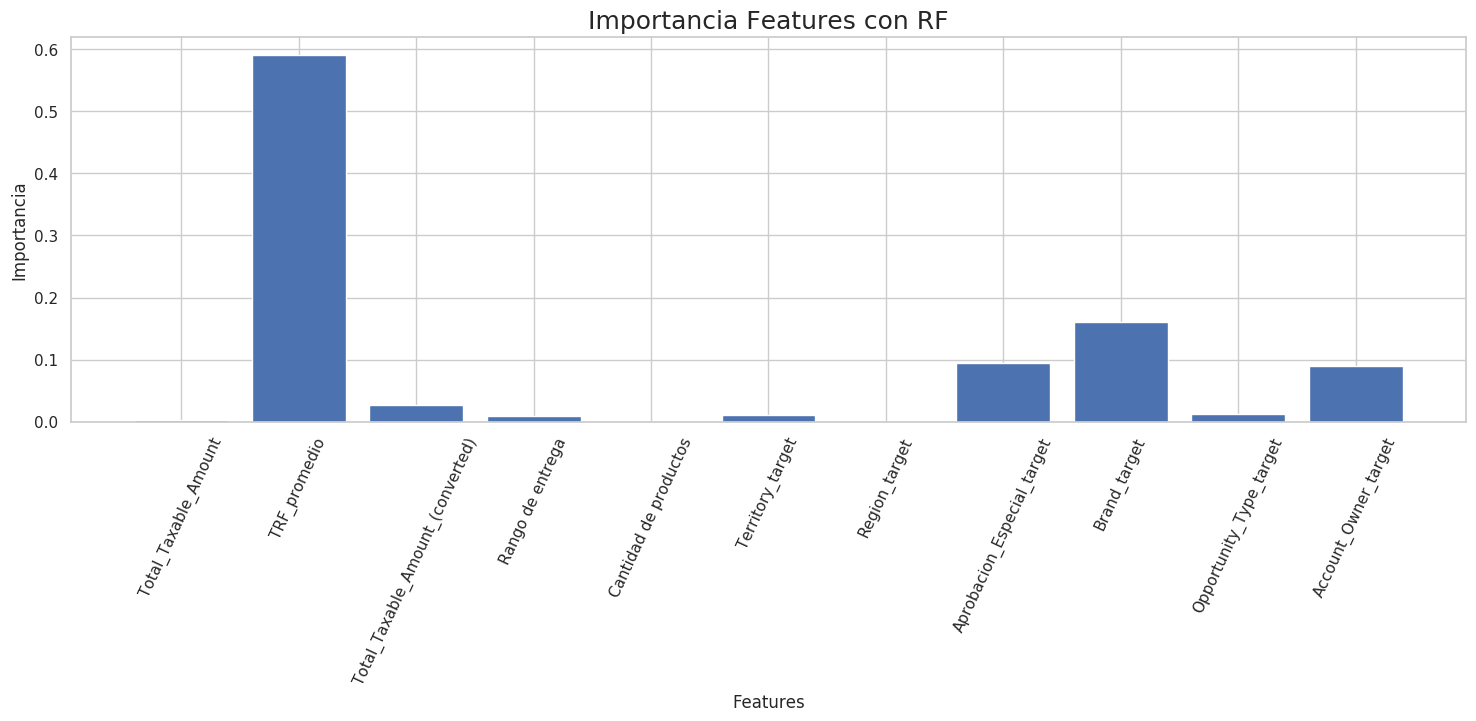

In [43]:
plt.bar(train_data.columns, modeloRFR.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF', fontsize=18)
plt.xticks(rotation=65)
plt.show()

## XGBoost

In [47]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=140,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)
#Con estos valores me dio un score en kaggle parecido al del RF 

__GridSearh Cross Validation__

In [50]:
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data=dtrain, label=predictors)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
           metrics="logloss", as_pandas=True, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain, predictors)

    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    logloss = log_loss(predictors, dtrain_predprob)
    print("Logloss: %f" % (logloss))
    print((cvresult["test-logloss-mean"]).tail(1))

In [52]:
modelfit(xgb1, train_data, train_label)

[10:29:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Model Report
RMSLE: 0.327650
139                   0.38
Name: test-logloss-mean, dtype: float64


In [54]:
#Primero seteo el learning rate alto y busco el max_depth y min_child_weight para este learning rate
#hay que ir bajando el learning rate para mejores parámetros
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=193, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, seed=27), 
 param_grid = param_test1, scoring=LogLoss,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_data,train_label)

print("Best parameters set found on development set:")
print(gsearch1.best_params_,gsearch1.best_score_)

print("Grid scores on development set:")
means = gsearch1.cv_results_['mean_test_score']
stds = gsearch1.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch1.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

[10:31:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 9, 'min_child_weight': 1}, 7.443433203888081)

In [55]:
#refino un poco la búsqueda
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=193, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, seed=27), 
 param_grid = param_test2, scoring=LogLoss,n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_data,train_label)
print("Best parameters set found on development set:")
print(gsearch2.best_params_,gsearch2.best_score_)

print("Grid scores on development set:")
means = gsearch2.cv_results_['mean_test_score']
stds = gsearch2.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

[10:31:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 10, 'min_child_weight': 1}, 7.073049527852429)

In [56]:
#Busco valor de gama optimo,
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=193, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, seed=27), 
 param_grid = param_test3, scoring=LogLoss,n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_data,train_label)
print("Best parameters set found on development set:")
print(gsearch3.best_params_,gsearch3.best_score_)

print("Grid scores on development set:")
means = gsearch3.cv_results_['mean_test_score']
stds = gsearch3.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

[10:31:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.0}, 7.284679442842856)

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(4,7)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=193, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4,seed=27), 
 param_grid = param_test4, scoring=LogLoss,n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_data,train_label)
print("Best parameters set found on development set:")
print(gsearch4.best_params_,gsearch4.best_score_)

print("Grid scores on development set:")
means = gsearch4.cv_results_['mean_test_score']
stds = gsearch4.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch4.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

In [ ]:
#otra vez busco con valores más cercanos
param_test5 = {
 'subsample':[i/100.0 for i in range(50,70,5)],
 'colsample_bytree':[i/100.0 for i in range(70,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=193, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, seed=27), 
 param_grid = param_test5, scoring=LogLoss,n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_data,train_label)
print("Best parameters set found on development set:")
print(gsearch5.best_params_,gsearch5.best_score_)

print("Grid scores on development set:")
means = gsearch5.cv_results_['mean_test_score']
stds = gsearch5.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch5.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

In [ ]:
#no puedo encontrar valores de alpha ni lambda como la gente...
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=193, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.6, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, seed=27), 
 param_grid = param_test6, scoring=LogLoss,n_jobs=4,iid=False, cv=5)
gsearch6.fit(train_data,train_label)
print("Best parameters set found on development set:")
print(gsearch6.best_params_,gsearch6.best_score_)

print("Grid scores on development set:")
means = gsearch6.cv_results_['mean_test_score']
stds = gsearch6.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch6.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

In [ ]:
param_test8 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=193, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.6, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, seed=27), 
 param_grid = param_test8, scoring=LogLoss,n_jobs=4,iid=False, cv=5)
gsearch8.fit(train_data,train_label)
print("Best parameters set found on development set:")
print(gsearch8.best_params_,gsearch8.best_score_)

print("Grid scores on development set:")
means = gsearch8.cv_results_['mean_test_score']
stds = gsearch8.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch8.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

__Predicción__

In [ ]:
#luego del grid search llego a que los mejores parametros son
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=193,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

In [ ]:
xgb2.fit(train_data,train_label)
#aca predice 1 y 0
preds2= xgb2.predict(test)
#acá la probabilidad de que sea 1 y 0
preds = xgb2.predict_proba(test)[:,1]
entregable_XGBoost = IDs[['Opportunity_ID']].copy()
entregable_XGBoost['Target'] = preds

## LightGBM

In [ ]:
lgb_train = lgb.Dataset(train_data, train_label)
lgb_eval = lgb.Dataset(train_data, train_label, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

params = {
    'objective': 'regression',
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

preds = gbm.predict(train_data, num_iteration=gbm.best_iteration)
logLoss = log_loss(train_label, preds)
print("logLoss: %f" % (logLoss))

In [ ]:
#dio un score malisimo en kagle 1.0 algo
result = gbm.predict(test, num_iteration=gbm.best_iteration)

entregable_GBM = IDs[['Opportunity_ID']].copy()
entregable_GBM['Target'] = result